In [ ]:
# import the packages
import os
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import pandas as pd
import glob
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

#import the tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

import glob
import cv2 as cv


from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.9.2


In [ ]:
pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 6.7 MB/s 
     |████████████████████████████████| 1.6 MB 38.1 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=d84a917450635caf32d9bf8d7adf9c7b33dac079911edc58cf511178e484caab
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ad21966ab0472012b4f9a57a0c315d08b36f9b2afa4fbf3e63c5fafe2b3a5271
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=74b55284ed583faed0651bac15f4f45bc8f7b6df72cf4c2f693e3776bb94da93
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

No GPU


In [ ]:
#define the number of classes of the image

num_classes = 2

#this is a function to make sure the labels go from 0- (num_classes-1)
def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [ ]:
#build data flow routines, getting the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.2

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = '/content/drive/MyDrive/updated_images/train/images' 
label_dir = '/content/drive/MyDrive/updated_images/train/labels'

#to make it deterministic, set the seed
SEED = 11

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split)

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 3

#set Image size. We are using a UNET based on Segmentation Zoo.. 
# size choices are:
#
#(RGB so imshape is 3)
pix_dim_x = 1024
pix_dim_y = 1024
imsize = (pix_dim_x,pix_dim_y) 
imshape = (pix_dim_x,pix_dim_y,3)

masksize = (pix_dim_x,pix_dim_y)


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)



# Flow validation images in batches 


val_image_generator = train_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = train_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)

Found 1400 images belonging to 1 classes.
Found 1400 images belonging to 1 classes.
Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.


In [ ]:
#Set total number of images in each subset, which is the output from the above cell.
# this will be used later when we train the model
total_train = 600
total_val = 90

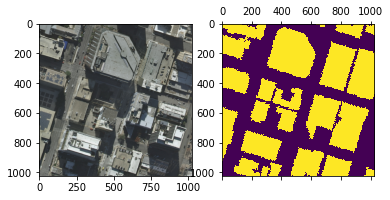

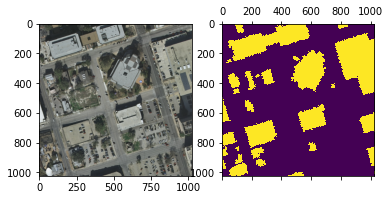

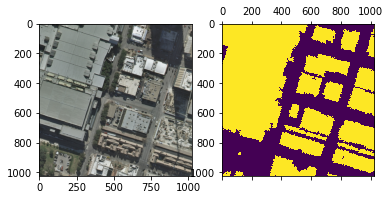

In [ ]:
#lets look at the output of the generator.
#for a full training batch... 

x,y = next(train_generator)
#x,y = next(validation_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 1)
#     print(np.amax(lab.squeeze()))
#     print(np.amin(lab.squeeze()))
#     actual_lab = lab.squeeze()
#     print(lab.shape)

In [ ]:
#the model
nstrides = (1,1)

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation

#first we define the inputs, which is the shape of images defined in the code blocks above 
inputs = layers.Input(imshape)

# now we set up 4 blocks of comvolutons in the 'encoder' part
#block1
conv01 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(inputs)
conv1 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conv01)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#block2
conv02 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(pool1)
conv2 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conv02)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#block3
conv03 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(pool2)
conv3 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conv03)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#block4
conv04 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(pool3)
conv4 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conv04)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

#bottlneck
conv05 = layers.Conv2D(512, 4, activation = 'relu', strides = nstrides, padding="same")(pool4)
conv5 = layers.Conv2D(512, 4, activation = 'relu', strides = nstrides, padding="same", )(conv05)
upconv5 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides = (2,2))(conv5)

#upblock 1
conc6 = layers.concatenate([upconv5, conv4])
conv06 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conc6)
conv6 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conv06)
up7 = layers.Conv2DTranspose(126, kernel_size=(2, 2), strides = (2,2))(conv6)

#upblock 2
conc7 = layers.concatenate([up7, conv3])
conv07 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conc7)
conv7 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conv07)
up8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides = (2,2))(conv7)

#upblock 3
conc8 = layers.concatenate([up8, conv2])
conv08 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conc8)
conv8 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conv08)
up9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides = (2,2))(conv8)

#upblock 4
conc9 = layers.concatenate([up9, conv1])
conv09 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conc9)
conv9 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conv09)

#we define the outputs here
outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(conv9)


#combine the model together
model = Model(inputs, outputs)

#and print out the text summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   1568        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   16416       ['conv2d[0][0]']                 
                                32)                                                           

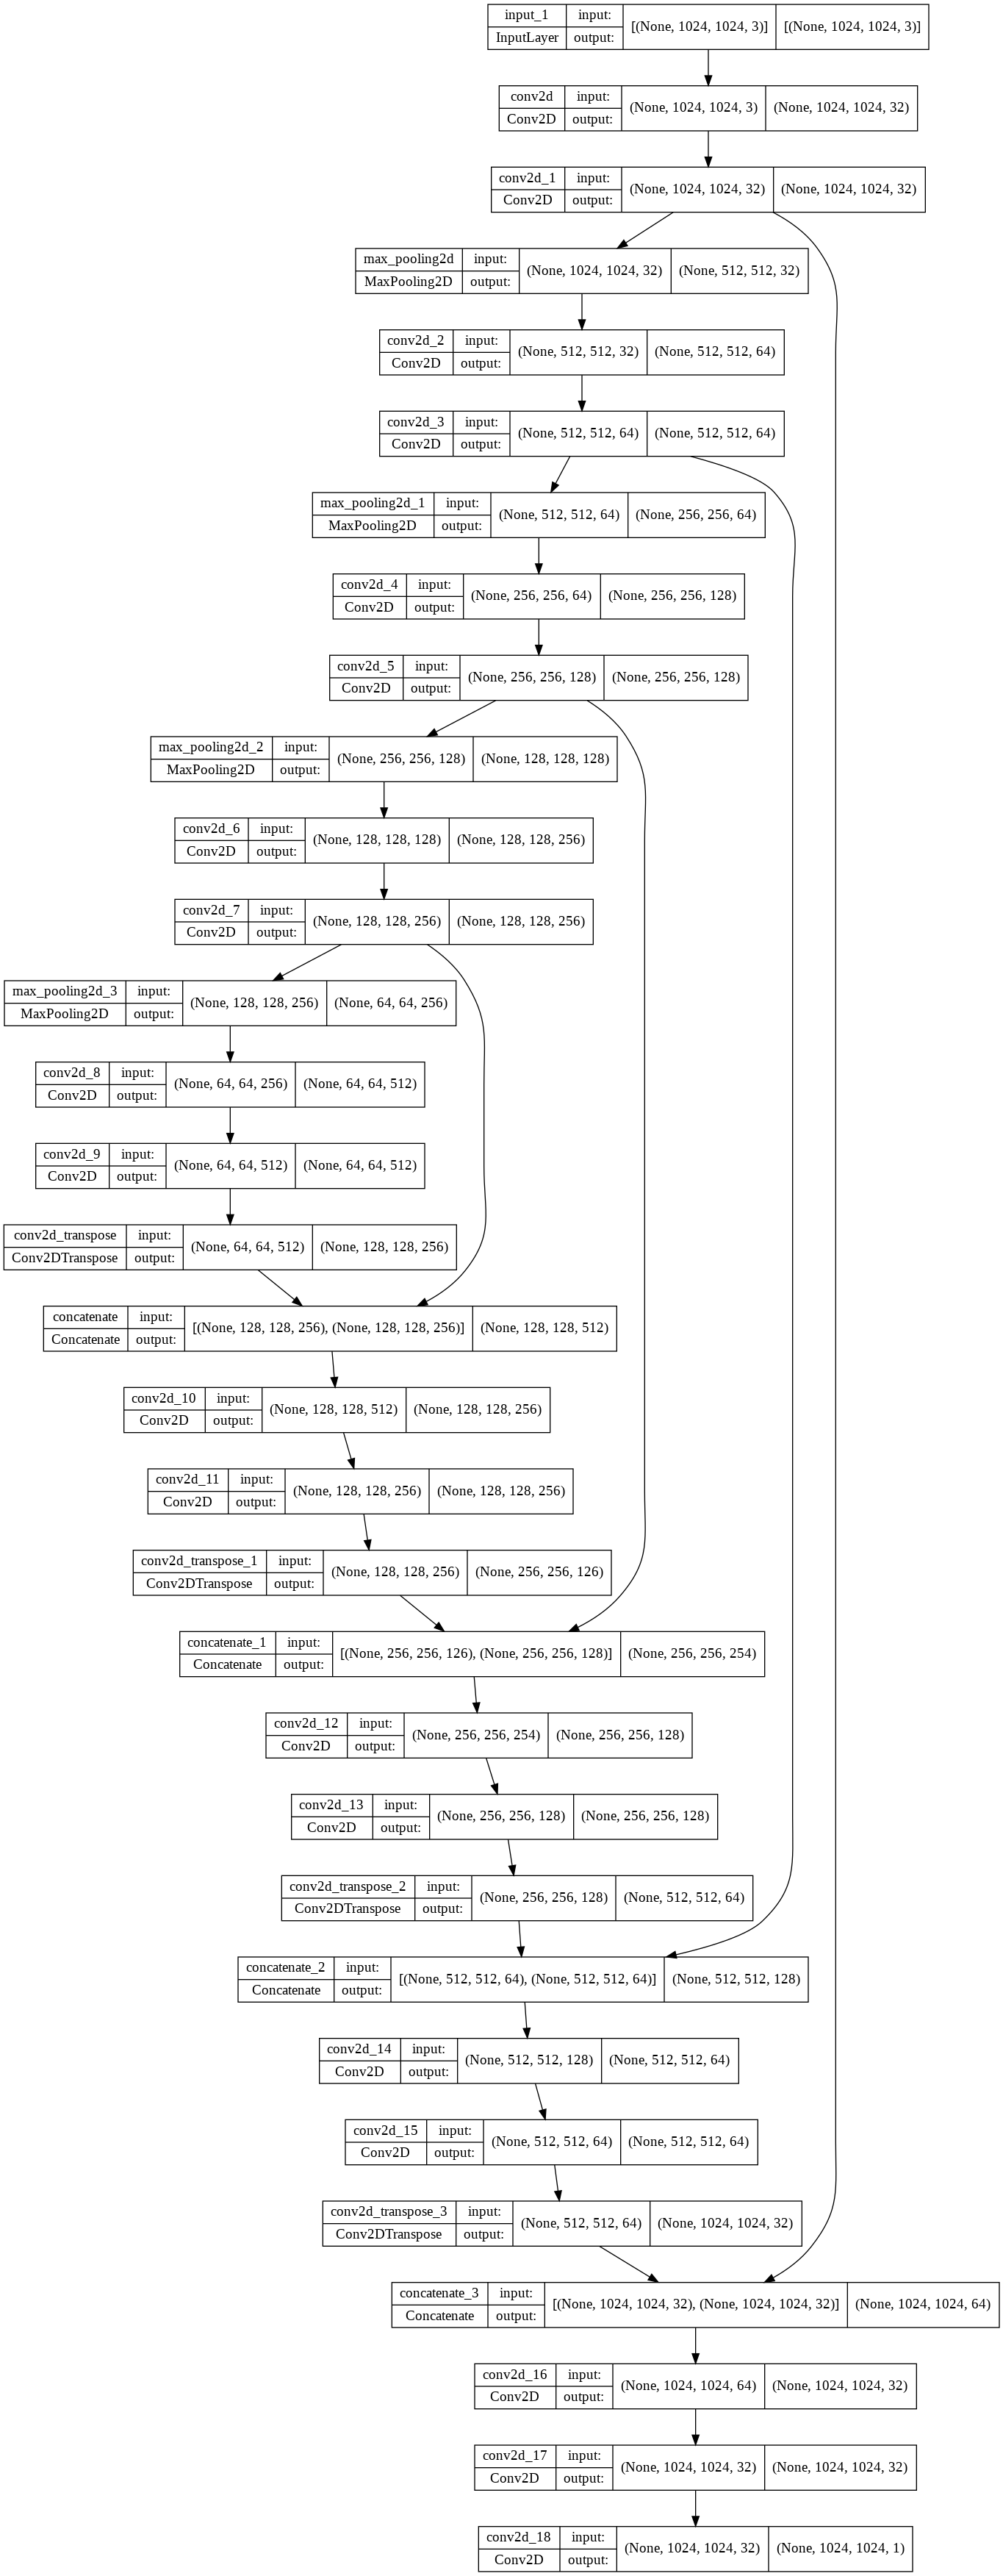

In [ ]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile( loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
#we compile the model, set a loss function, and also an optimizer. 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [ ]:
#lets now train the model! We can store all the model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for some number of epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 3,
                    workers = 24,
                    steps_per_epoch = total_train // batch_size,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/3


In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
#plt.grid(True)
plt.show

In [ ]:
#now that training is done, lets look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
#Save the model
model.save("./drive/My Drive/Priyanka_new_savedmodel.h5")

In [ ]:
#loading the trained model
from tensorflow import keras
reconstructed_model = keras.models.load_model("./drive/My Drive/Priyanka_new_savedmodel.h5")
reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   1568        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   16416       ['conv2d[0][0]']                 
                                32)                                                           

In [ ]:
#printing the layers with index and name
for i, layer in enumerate(reconstructed_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 conv2d_1
3 max_pooling2d
4 conv2d_2
5 conv2d_3
6 max_pooling2d_1
7 conv2d_4
8 conv2d_5
9 max_pooling2d_2
10 conv2d_6
11 conv2d_7
12 max_pooling2d_3
13 conv2d_8
14 conv2d_9
15 conv2d_transpose
16 concatenate
17 conv2d_10
18 conv2d_11
19 conv2d_transpose_1
20 concatenate_1
21 conv2d_12
22 conv2d_13
23 conv2d_transpose_2
24 concatenate_2
25 conv2d_14
26 conv2d_15
27 conv2d_transpose_3
28 concatenate_3
29 conv2d_16
30 conv2d_17
31 conv2d_18


In [ ]:
#extracting the bottle neck layer
bottle_neck_model = tf.keras.models.Model([reconstructed_model.get_layer(index = 0).input] ,  [reconstructed_model.get_layer(index= 16).output])

In [ ]:
bottle_neck_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   1568        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   16416       ['conv2d[0][0]']                 
                                32)                                                           

In [ ]:
# Resize image for multiple images 

In [ ]:
#https://www.youtube.com/watch?v=Y6NRFru9WLg
#https://stackoverflow.com/questions/63297838/how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction


path = "/content/drive/MyDrive/updated_images/test/SampleImages/*.jpg"
#path = "/content/drive/MyDrive/updated_images/test/images/*.jpg"

count = 0
multiimage_tensors = []

for image in glob.glob(path):
    n = cv2.imread(image)
    #print(n.shape)
    multim_resize = cv2.resize(n , (1024 ,1024))
    #print(im_resize.shape)
    multim_resize = np.expand_dims(multim_resize, axis = 0)
    #print(im_resize.shape)
    bottle_neck_model_tensors = bottle_neck_model([multim_resize])[0]
    multiimage_tensors.append(bottle_neck_model_tensors)
    count = count + 1

print("The number of images :" , count)

The number of images : 85


In [ ]:
#Save the tensors in a file
np.save("/content/drive/MyDrive/multi_tensor.npy" , multiimage_tensors)

In [ ]:
#load the tensors from the file
multiimage_tensors = np.load("/content/drive/MyDrive/multi_tensor.npy")
multiimage_tensors.shape

(85, 128, 128, 512)

In [ ]:
#convert to numpy array
arr = np.asarray(multiimage_tensors)
print(type(arr))
arr.shape

<class 'numpy.ndarray'>


(85, 128, 128, 512)

In [ ]:
numarr = []

for i in range(len(multiimage_tensors)):
  p = arr[i].flatten()
  numarr.append(p)

In [ ]:
len(numarr)

85

In [ ]:
numarr = np.asarray(numarr)
print(type(numarr))
numarr.shape

<class 'numpy.ndarray'>


(85, 8388608)

In [ ]:
#Save the final Array
np.save("/content/drive/MyDrive/numarr.npy" ,numarr)

In [ ]:
#load the array
numarr = np.load("/content/drive/MyDrive/numarr.npy")

In [ ]:
#Referred the below site to perform the below task : 
# https://www.youtube.com/watch?v=uFbDWu0tDrE
# https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29
 
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
pca.fit(numarr)
data_pca = pca.transform(numarr)
print("original shape:   ", numarr.shape)
print("transformed shape:", data_pca.shape)

original shape:    (85, 8388608)
transformed shape: (85, 2)


In [ ]:
print("Cumulative Variances (Percentage):")
print(pca.explained_variance_ratio_.cumsum() * 100)

Cumulative Variances (Percentage):
[52.086376 63.56271 ]


In [ ]:
#import cv2
# https://stackoverflow.com/questions/49186905/loading-images-in-google-colab
#/content/drive/MyDrive/updated_images/test/SampleImages/bellingham1-13.jpg


image_names = os.listdir('/content/drive/MyDrive/updated_images/test/SampleImages/')
print (image_names)

img_url  = []
for each_image in image_names:
   if each_image.endswith(".jpg"):
    full_path = "/content/drive/MyDrive/updated_images/test/SampleImages/" + each_image
    img_url.append(full_path)

['bellingham4-6.jpg', 'bellingham4-3.jpg', 'bellingham4-4.jpg', 'bellingham4-2.jpg', 'bellingham4-1.jpg', 'bellingham4-9.jpg', 'bellingham2-15.jpg', 'bellingham3-8.jpg', 'bellingham2-8.jpg', 'bellingham3-20.jpg', 'bellingham2-7.jpg', 'bellingham3-10.jpg', 'bellingham3-18.jpg', 'bellingham3-19.jpg', 'bellingham3-2.jpg', 'bellingham3-12.jpg', 'bellingham3-9.jpg', 'bellingham3-7.jpg', 'bellingham2-10.jpg', 'bellingham2-1.jpg', 'bellingham3-1.jpg', 'bellingham3-15.jpg', 'bellingham3-0.jpg', 'bellingham2-23.jpg', 'bellingham3-24.jpg', 'bellingham3-4.jpg', 'bellingham2-2.jpg', 'bellingham2-13.jpg', 'bellingham4-7.jpg', 'bellingham4-5.jpg', 'bellingham3-3.jpg', 'bellingham3-17.jpg', 'bellingham3-14.jpg', 'bellingham3-23.jpg', 'bellingham3-11.jpg', 'bellingham3-5.jpg', 'bellingham2-22.jpg', 'bellingham4-8.jpg', 'bellingham3-16.jpg', 'bellingham3-22.jpg', 'bellingham3-21.jpg', 'bellingham2-24.jpg', 'bellingham3-6.jpg', 'bellingham2-3.jpg', 'bellingham4-0.jpg', 'bellingham3-13.jpg', 'bellingham2

In [ ]:
#save the image url
img_url = pd.DataFrame(img_url)
img_url.to_pickle('/content/drive/MyDrive/img_url.pkl')

In [ ]:
len(img_url)

85

In [ ]:
#https://www.geeksforgeeks.org/python-pil-image-open-method/
#https://dash.plotly.com/dash-enterprise/static-assets

from PIL import Image
display_array = []
for i in img_url:
  image_path =  Image.open(i)
  display_array.append(image_path)

In [ ]:
df = pd.DataFrame(data_pca)
df['image_url'] = display_array

df = df.rename( columns ={ 0 : "column1", 1: "column2"})
df.head(5)

,column1,column2,image_url
0,-271324.34375,69383.296875,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,-324565.59375,-14545.806641,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,-210888.84375,32929.179688,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,-361125.18750,-86254.859375,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,-433172.12500,-18901.222656,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
#create a pickle file to save the dataframe
df.to_pickle("/content/drive/MyDrive/df.pkl")

In [ ]:
#read the pickle file
df = pd.read_pickle("/content/drive/MyDrive/df.pkl")

Text(0, 0.5, 'Pricipal Component 2')

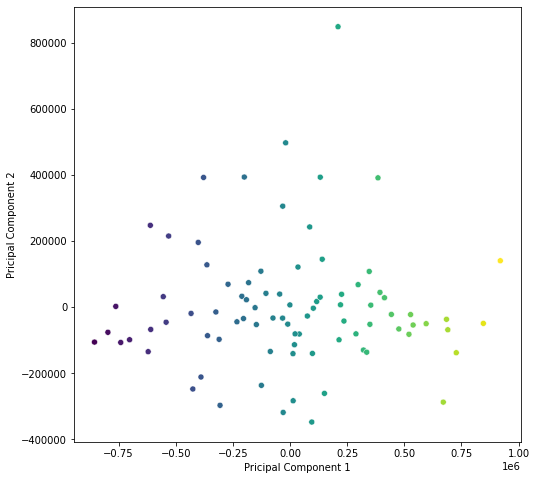

In [ ]:
plt.figure(figsize=(8,8))
import seaborn as sns

p = sns.scatterplot(x= df['column1'], y= df['column2'] , c = df['column1'])
p.set_xlabel("Pricipal Component 1")
p.set_ylabel("Pricipal Component 2")

In [ ]:
#https://stackoverflow.com/questions/70050831/plotly-dash-scatter-plot-pointnumber-is-assigned-to-multiple-points-in-hover-da
#https://community.plotly.com/t/how-to-embed-images-into-a-dash-app/61839

from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.express as px


# Setup plotly scatter plot
fig = px.scatter(x= df['column1'], y=df['column2'] , color = df['column1'], labels=dict( x ="Principal Component 1", y ="Principal Component 2") , color_continuous_scale='viridis' )

fig.update_traces(hoverinfo="none", hovertemplate=None)


# Setup Dash
app = JupyterDash(__name__)
app.layout = html.Div(className="container",
                      children=[dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                                dcc.Tooltip(id="graph-tooltip-5", direction="bottom")])

@app.callback(Output("graph-tooltip-5", "show"),
              Output("graph-tooltip-5", "bbox"),
              Output("graph-tooltip-5", "children"),
              Input("graph-5", "hoverData"))

def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update
    

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    
    df_row = df.iloc[num]
    img_src = df_row['image_url']
   
   
    children = [
        html.Div([
            html.Img(src=img_src, style={"width": "100%"})
        ], style={'width': '100px', 'white-space': 'normal'})
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode="inline", debug=True)

<IPython.core.display.Javascript object>

In [ ]:
#TSNE  - https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29

from sklearn.manifold import TSNE
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_data = tsne.fit_transform(numarr)
print("original shape:   ", numarr.shape)
print("transformed shape:", tsne_data.shape)

In [ ]:
df_tsne = pd.DataFrame(tsne_data)
df_tsne['image_url'] = display_array

df_tsne = df_tsne.rename( columns ={ 0 : "column1", 1: "column2" , 2 : "image_url"})
df_tsne.head(5)

,column1,column2,image_url
0,-3.111238,-1.369902,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,-3.441723,-1.707379,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,-2.918055,-1.313454,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,-3.638565,-2.013741,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,-4.092244,-2.020872,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
df_tsne.to_pickle("/content/drive/MyDrive/df_tsne.pkl")

In [ ]:
df_tsne = pd.read_pickle("/content/drive/MyDrive/df_tsne.pkl")

Text(0, 0.5, ' TSNE 2')

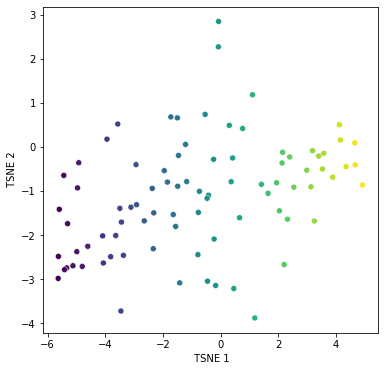

In [ ]:
plt.figure(figsize=(6,6))
import seaborn as sns

p = sns.scatterplot(x= df_tsne['column1'], y=df_tsne['column2'] , c = df_tsne['column1'] )
p.set_xlabel(" TSNE 1")
p.set_ylabel(" TSNE 2")

In [ ]:
#https://stackoverflow.com/questions/70050831/plotly-dash-scatter-plot-pointnumber-is-assigned-to-multiple-points-in-hover-da

from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.express as px


# Setup plotly scatter plot
fig = px.scatter(x= df_tsne['column1'], y=df_tsne['column2'] ,  color = df_tsne['column1']  , labels=dict( x ="TSNE1", y ="TSNE2") , color_continuous_scale='Agsunset' )

fig.update_traces(hoverinfo="none", hovertemplate=None)


# Setup Dash
app = JupyterDash(__name__)
app.layout = html.Div(className="container",
                      children=[dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                                dcc.Tooltip(id="graph-tooltip-5", direction="bottom")])

@app.callback(Output("graph-tooltip-5", "show"),
              Output("graph-tooltip-5", "bbox"),
              Output("graph-tooltip-5", "children"),
              Input("graph-5", "hoverData"))

def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update
    

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    
    df_row = df_tsne.iloc[num]
    img_src = df_row['image_url']
   
   
    children = [
        html.Div([
            html.Img(src=img_src, style={"width": "100%"})
        ], style={'width': '100px', 'white-space': 'normal'})
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode="inline", debug=True)

<IPython.core.display.Javascript object>

In [ ]:
# Umap - https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29

In [ ]:
import umap.umap_ as umap
Umap = umap.UMAP(random_state=42,n_components=2)
Umap_data = Umap.fit_transform(numarr)
print("original shape:   ", numarr.shape)
print("transformed shape:", Umap_data.shape)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



original shape:    (85, 8388608)
transformed shape: (85, 2)


In [ ]:
df_umap = pd.DataFrame(Umap_data)
df_umap['image_url'] = display_array

df_umap = df_umap.rename( columns ={ 0 : "column1", 1: "column2"})
df_umap.head(5)

,column1,column2,image_url
0,4.335698,7.392283,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,3.832554,7.948028,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,3.965873,7.363616,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,4.171454,8.304070,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,4.223282,8.432046,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
df_umap.to_pickle("/content/drive/MyDrive/df_umap.pkl")

In [ ]:
df_umap = pd.read_pickle("/content/drive/MyDrive/df_umap.pkl")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



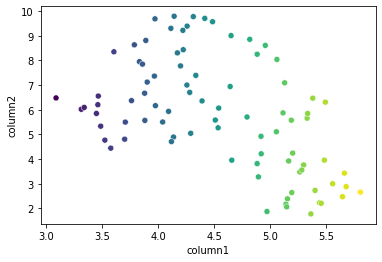

In [ ]:
p = sns.scatterplot(df_umap['column1'], df_umap['column2'] , c = df_umap['column1'])

In [ ]:
#https://stackoverflow.com/questions/70050831/plotly-dash-scatter-plot-pointnumber-is-assigned-to-multiple-points-in-hover-da

from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.express as px


# Setup plotly scatter plot
fig = px.scatter(x= df_umap['column1'], y=df_umap['column2'] ,  color = df_umap['column1']  , labels=dict( x =" Umap1", y ="Umap2") , color_continuous_scale='ice' )

fig.update_traces(hoverinfo="none", hovertemplate=None)


# Setup Dash
app = JupyterDash(__name__)
app.layout = html.Div(className="container",
                      children=[dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                                dcc.Tooltip(id="graph-tooltip-5", direction="bottom")])

@app.callback(Output("graph-tooltip-5", "show"),
              Output("graph-tooltip-5", "bbox"),
              Output("graph-tooltip-5", "children"),
              Input("graph-5", "hoverData"))

def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update
    

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    
    df_row = df_umap.iloc[num]
    img_src = df_row['image_url']
   
   
    children = [
        html.Div([
            html.Img(src=img_src, style={"width": "100%"})
        ], style={'width': '100px', 'white-space': 'normal'})
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode="inline", debug=True)

<IPython.core.display.Javascript object>

In [ ]:
# https://plotly.com/python/subplots/

from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(x= df['column1'], y= df['column2']  , mode='markers') , row=1, col=1)

fig.add_trace(go.Scatter(x= df_tsne['column1'], y=df_tsne['column2'] , mode='markers' ), 
    row=1, col=2)

fig.add_trace(go.Scatter(x= df_umap['column1'], y=df_umap['column2'] , mode='markers' ) , 
    row=1, col=3
)

fig.update_layout(height=600, width=1000, title_text=" PCA , TSNE , UMAP Subplots")

fig.show()

In [ ]:
#Create a Dashboard

In [ ]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.express as px


app = JupyterDash(__name__)

app.layout = html.Div([dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                       dcc.Tooltip(id="graph-tooltip-5", direction="bottom"), 

         html.Br(),

         html.Br(),

         dcc.Dropdown( id='dropdown',
                options=[{'label': 'PCA', 'value': 'PCA'}, 
                         {'label': 'TSNE' , 'value': 'TSNE'},
                         {'label': 'UMAP' , 'value': 'UMAP'}],
                value='PCA'
            ),

          
])

#Define callback to update graph 
@app.callback(
    Output("graph-5", "figure"),
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
    Input("dropdown", "value")
    )

def update_figure(hoverData,value):
  
  if value == 'PCA':
    print("PCA")
    df_new = df
    x= df_new['column1']
    y= df_new['column2']
    fig = px.scatter( df_new , x ='column1'  , y ='column2' , color = 'column1'  , labels= {'column1':"PCA1", 'column2': "PCA2"}, color_continuous_scale='viridis' )
		#return fig
  elif value == 'TSNE':
    print("TSNE")
    df_new = df_tsne
    x = df_new['column1']
    y = df_new['column2']
    fig = px.scatter(df_new , x ='column1'  , y ='column2' , color = 'column1' , labels= {'column1':"TSNE1", 'column2': "TSNE2"}, color_continuous_scale='Agsunset' )
        #return fig    
  elif value == 'UMAP':
    print("UMAP")
    df_new = df_umap
    x = df_new['column1']
    y = df_new['column2']
    fig = px.scatter(df_new , x ='column1'  , y ='column2' , color = 'column1' , labels= {'column1':"UMAP1", 'column2': "UMAP2"}, color_continuous_scale='ice' )
    #return fig
   
  #scatter_fig = px.scatter( x , y ,  labels=dict( x ="TSNE1", y ="TSNE2") , color_continuous_scale='Agsunset' )
  fig.update_traces(hoverinfo="none", hovertemplate=None)
  if hoverData is None:
    return fig,False, no_update, no_update

  hover_data = hoverData["points"][0]
  bbox = hover_data["bbox"]
  num = hover_data["pointNumber"]

    
  df_row = df_new.iloc[num]
  img_src = df_row['image_url']
  #name = df_row['column1']
  #form = df_row['column2']
   
  children = [
        html.Div( children = [ 
            html.Img(src=img_src, style={"width": "100%"})
        ], style={'width': '100px', 'white-space': 'normal'})
    ]

  return fig,True, bbox, children

#Run app and display result inline in the notebook
app.run_server(mode = 'inline' , debug = True)

<IPython.core.display.Javascript object>

In [ ]:
# References : 

#* https://stackoverflow.com/questions/67102278/expected-ndim-3-found-ndim-4-when-using-k-function-in-keras-backend-to-get-i
#* https://stackoverflow.com/questions/66079482/why-would-we-expand-a-numpy-array-along-axis-0
#* https://stackoverflow.com/questions/67856458/how-to-append-multiple-image-into-a-ndarray
#* https://www.youtube.com/watch?v=uFbDWu0tDrE